# Getting Started

AtomDB is tailored for accessing atomic properties and, in some cases, leveraging them to obtain approximate molecular properties (pro-molecule models).  The library is designed to be lightweight and easy to use with the goal of providing first approximation when the cost of more accurate calculations is prohibitive (e.g. high size of the system like in proteins with thousands of atoms or in cases where there are thousands of different atomic species like in high-throughput screening or molecular dynamics simulations). This notebook provides a quick overview of the main features of AtomDB and how to use it as a Python script or library.


## Use as a Python script

AtomDB supports usage as a Python script for obtaining properties from the command line. While the script is not as feature-rich as the library, it is still useful for quick fetching of atomic properties. The next cell demonstrates how to utilize AtomDB as a Python script to retrieve atom properties.

Note that to execute it (in a command line environment), you'll need to remove the ! from the beginning of the lines.

**Getting help on the script**: In the following cell, we show how to get help on the script.

In [73]:
!python -m atomdb -h

usage: atomdb [-h] (-c | -q) [-e EXC] dataset elem charge mult

Compile or query an AtomDB entry.

options:
  -h, --help         show this help message and exit

commands:
  -c, --compile      compile a species into the database
  -q, --query        query a species from the database

arguments:
  dataset            name of dataset
  elem               element symbol
  charge             charge
  mult               multiplicity
  -e EXC, --exc EXC  excitation level


**Printing atom properties using the script:**

The data is printed as human readable following the JSON format. This can be latter parsed and used 
in other scripts or programs. The following cell shows how to print the data for the Carbon atom with
charge 0 and spin multiplicity 3 (ground state). Due to the large amount of data, from the output stored
in the variable c_0_3_json_output only three properties are parsed and printed.

In [74]:
%%bash 
c_0_3_json_output=$(python -m atomdb -q slater C 0 3)

# Define an array of keys
keys=("elem" "atnum" "atmass")

# Loop through the keys and print the raw-values from the JSON output
for key in "${keys[@]}"; do
    value=$(echo "$c_0_3_json_output" | jq -r ".$key")
    echo "$key: $value"
done

elem: C
atnum: 6
atmass: 21893.98446012775


## Use as a Python library

The real power of AtomDB is showcased when it is used as a library. The library provides a simple API to access atomic properties and even some pro-molecular properties. This is done through the `Species` object, which is used to access atomic properties. 


The required inputs are: element symbol, charge and multiplicity. 

Optionally a dataset name can be specified choosing one of:
- `nist`: NIST spectroscopic data complemented with results from [Phys. Chem. Chem. Phys., 2016,18, 25721-25734](https://doi.org/10.1039/C6CP04533B)
- `slater`: Atomic orbitals and electronic denisty properties from SCF calculations using Slater basis.
- `numeric`: electronic denisty properties from numerical Hartree-fock calculations.
- `gaussian`: Atomic orbitals and electronic denisty properties from SCF calculations using gaussian basis. 

The following cell demonstrates how to create a `Species` object for the `C` atom with charge 0 and spin multiplicity 3. Subsequent cells show how to access some of its atomic properties.

In [75]:
from atomdb import load

c_slater = load(elem='C', charge=0, mult=3, dataset='slater')

#### Scalar atomic properties:

The following cell demonstrates how to extract scalar atomic properties atomic number, atomic mass, atomic symbol.
Please note that some properties have more than one reference value, in this case a dictionary is returned with the
 reference as key and the value as value (see the atomic radius).

In [76]:
print(f"Element loaded {c_slater.elem}")
print(f"Charge {c_slater.charge}")
print(f"Multiplicity {c_slater.mult}")
print(f"Number of electrons {c_slater.nelec}")
print(f"Atomic number {c_slater.atnum}")
print(f"Atomic mass in a.u. {c_slater.atmass}")
print(f"Atomic radius in a.u. {c_slater.at_radius}")

Element loaded C
Charge 0
Multiplicity 3
Number of electrons 6
Atomic number 6
Atomic mass in a.u. 21893.98446012775
Atomic radius in a.u. {'wc': 1.1716301972646734, 'cr': 1.2661165034956954}


#### Vector-type atomic properties:

The following cell demonstrates how to extract vector atomic properties such as the orbital energies and the occupation numbers.

In [77]:
# Atomic orbitals information
print(f"Number of spin-orbitals (alpha): {c_slater.ao.norba}")
print(f"Number of spin-orbitals (beta): {c_slater.ao.norbb}")
print(f"Occupations (alpha): {c_slater.ao.occs_a}")
print(f"Occupations (beta): {c_slater.ao.occs_b}")
print(f"Orbital energies (alpha): {c_slater.ao.energy_a}")
print(f"Orbital energies (beta): {c_slater.ao.energy_b}")

Number of spin-orbitals (alpha): 5
Number of spin-orbitals (beta): 5
Occupations (alpha): [1 1 1 1 0]
Occupations (beta): [1 1 0 0 0]
Orbital energies (alpha): [-11.3255187  -0.7056273  -0.4333405  -0.4333405  -0.4333405]
Orbital energies (beta): [-11.3255187  -0.7056273  -0.4333405  -0.4333405  -0.4333405]


#### Function type atomic properties:

The `Species` instances also contain information on atomic properties that are functions the spatial coordinates such as the electron density and the atomic orbitals. For these properties, the only the radial part is returned.

The following cell demonstrates how to extract the radial part of the electron density.

In [78]:
import numpy as np

# Define a uniform radial grid and evaluate the density
rad_grid = np.linspace(0., 6., num=100)
# density and kinetic energy density functions (total)
dens_spline = c_slater.dens_func(spin='t',log=True)
ked_spline = c_slater.ked_func(spin='t')

dens = dens_spline(rad_grid)
ked = ked_spline(rad_grid)

print(f"Max density: {np.max(dens):.4f} at r = {rad_grid[np.argmax(dens)]:.4f} Bohr")
print(f"Max KED: {np.max(ked):.4f} at r = {rad_grid[np.argmax(ked)]:.4f} Bohr")

Max density: 127.4572 at r = 0.0000 Bohr
Max KED: 106.1023 at r = 0.1818 Bohr


The following cell provides a graphical representation of the electron density and kinetic energy
density of the Carbon atom with charge 0 and spin multiplicity 3.

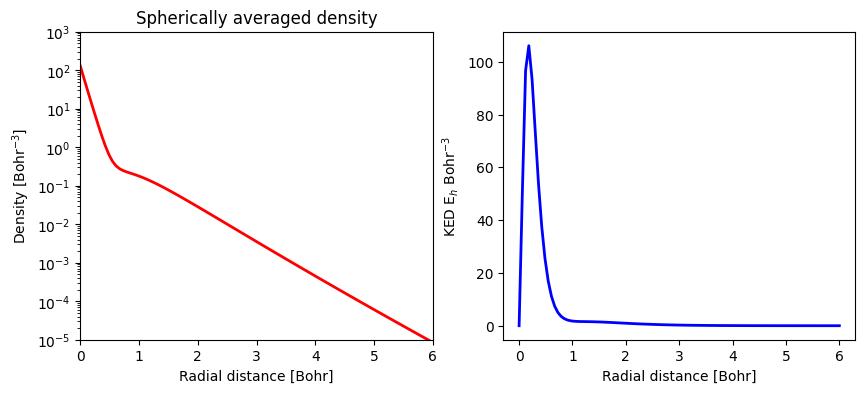

In [79]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(rad_grid, dens, '-r', linewidth=2)
ax1.set(xlabel="Radial distance [Bohr]", ylabel="Density [Bohr$^{-3}$]")
ax1.set_yscale('log')
ax1.set_ylim(top=1000, bottom=0.00001)
ax1.set_xlim(left=0., right=6)
ax1.set_title(f'Spherically averaged density')

ax2.plot(rad_grid, ked, '-b', linewidth=2)
ax2.set(xlabel="Radial distance [Bohr]", ylabel="KED E$_{h}$ Bohr$^{-3}$")
plt.show()

#### Dumping Data

In order to integrate AtomDB with other tools, it is possible to dump the data in a JSON format.
The data is then returned as a string with all the information of the `Species` object. The
following cell demonstrates how to dump the data for the carbon atom used in the previous examples.
Due to the large amount of data, only the first 90 characters are printed.

In [80]:
# Dumping Data to a JSON string
c_slater_json= c_slater.to_json()

# Print the first 90 characters of the JSON string
print(c_slater_json[:90])

{"elem": "C", "atnum": 6, "nelec": 6, "nspin": 2, "nexc": 0, "atmass": 21893.98446012775, 
